In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [2]:
import scipy.stats
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [3]:
from IPython.display import HTML, display
import tabulate

ModuleNotFoundError: No module named 'tabulate'

In [5]:
df_z = pd.read_parquet('../data/pre_processed/covid_cases_z_trans.parquet')

# K-means clustering

This notebook performs k-means clustering on the cleaned and z-transformed COVID infection data. The data is accumulated, meaning that if there where 10 new cases day 1 and 2 new cases day 2, number of cases on day 2 would be 12. The dataframe loaded from pre-processing has date as index (01-03-2020 -> 17-03-2020) and country name (string) as column name as shown below.

In [6]:
df_z.head(2)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,-1.016766,-0.704723,-1.314497,-2.128248,-1.062776,-0.974537,-1.38328,-2.021154,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828760,-1.206989,-1.733456,-1.337746,-0.739615,-0.683331
2020-03-02,-1.016766,-0.704723,-1.314127,-2.127737,-1.062476,-0.974537,-1.38328,-2.020472,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828718,-1.206979,-1.733456,-1.337746,-0.739615,-0.683331


The parameters used in this notebook where selected in the notebook parameter_selection -> k_means_parameter_testing by evaluating forecasting accuracies achieved with different hyperparameter combinations (accuracies stored and compared in notebook parameter_selection -> cluster_evaluation_results).

Using sklearn KMeans package to form clusters:

In [7]:
kmeans_z = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init=100, algorithm='auto').fit(df_z.T)

Array matching each country to its assigned cluster:

In [8]:
labels_kmeans_z = kmeans_z.labels_[:]
labels_kmeans_z

array([2, 2, 2, 3, 1, 1, 1, 3, 2, 2, 3, 1, 2, 2, 0, 1, 0, 3, 2, 2, 3, 2,
       3, 3, 1, 0, 0, 3, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 0, 2, 0,
       2, 0, 2, 3, 1, 3, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0,
       2, 0, 1, 1, 3, 3, 1, 0, 3, 2, 1, 3, 1, 1, 2, 2, 2])

Distribution of countries between clusters:

In [9]:
print("Countries in cluster 0:", np.count_nonzero(labels_kmeans_z == 0))
print("Countries in cluster 1:", np.count_nonzero(labels_kmeans_z == 1))
print("Countries in cluster 2:", np.count_nonzero(labels_kmeans_z == 2))
print("Countries in cluster 3:", np.count_nonzero(labels_kmeans_z == 3))

Countries in cluster 0: 12
Countries in cluster 1: 24
Countries in cluster 2: 30
Countries in cluster 3: 17


Creating a new dataframe for each cluster. The new formed dataframes have same format as df_z, however only the respective countries present in each cluster are included in each new dataframe. 

In [10]:
df_kmeans_z_0 = df_z.T.loc[labels_kmeans_z== 0].transpose()
df_kmeans_z_1 = df_z.T.loc[labels_kmeans_z == 1].transpose()
df_kmeans_z_2 = df_z.T.loc[labels_kmeans_z == 2].transpose()
df_kmeans_z_3 = df_z.T.loc[labels_kmeans_z == 3].transpose()

Plotting the created clusters:

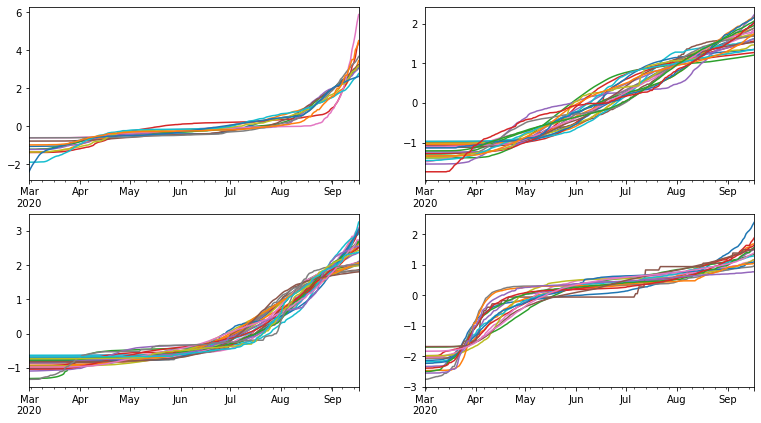

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
df_kmeans_z_0.plot(legend='', ax=axes[0,0])
df_kmeans_z_1.plot(legend='', ax=axes[0,1])
df_kmeans_z_2.plot(legend='', ax=axes[1,0])
df_kmeans_z_3.plot(legend='', ax=axes[1,1])

In [ ]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6)
fig.set_figwidth(40)


df_res.plot(legend='',ax=axs[0])

cases_popu.plot(legend='', ax=axs[1])

z_df.plot(legend='', ax=axs[2])
axs[0].set_title('Cases per country')
axs[1].set_title('Cases per country, divided by population')
axs[2].set_title('Cases per country, z-transformed')

for ax in axs.flat:
    ax.set(xlabel='Month')


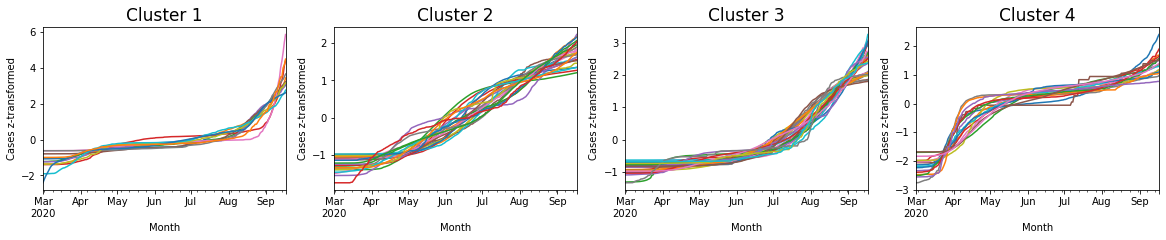

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(20, 3)
df_kmeans_z_0.plot(legend='', ax=axes[0])
df_kmeans_z_1.plot(legend='', ax=axes[1])
df_kmeans_z_2.plot(legend='', ax=axes[2])
df_kmeans_z_3.plot(legend='', ax=axes[3])

axes[0].set_title('Cluster 1', fontsize=17)
axes[1].set_title('Cluster 2', fontsize=17)
axes[2].set_title('Cluster 3', fontsize=17)
axes[3].set_title('Cluster 4', fontsize=17)



for ax in axes.flat:
    ax.set(xlabel='Month')
    ax.set(ylabel='Cases z-transformed')

### Cluster score

Scoring the clusters based on three chosen metrics, see delivered paper for more information on each score. Short summarized: it is desirable to achieve a high Silhouette score, low Davies Bouldin score and a high Calinski Harabasz score.

In [12]:
table = [["Method", "Score"],
        ["Silhouette score",round(silhouette_score(df_z.T, labels=labels_kmeans_z, metric='euclidean'),4)],
        ["Davies Bouldin score",round(davies_bouldin_score(df_z.T, labels=labels_kmeans_z),4)],
        ["Calinski Harabasz score",round(calinski_harabasz_score(df_z.T, labels=labels_kmeans_z),4)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

NameError: name 'tabulate' is not defined

#### Exporting clustering results

Cluster results are saved in parquet file. Later used in forecasting notebook forecasting -> forecasting_w_catboost_clusters

In [ ]:
#df_kmeans_z_0.to_parquet('../results/clustering_results/df_kmeans_z_0.parquet')
#df_kmeans_z_1.to_parquet('../results/clustering_results/df_kmeans_z_1.parquet')
#df_kmeans_z_2.to_parquet('../results/clustering_results/df_kmeans_z_2.parquet')
#df_kmeans_z_3.to_parquet('../results/clustering_results/df_kmeans_z_3.parquet')